<a href="https://colab.research.google.com/github/SANJAYKUMAR9324/DAA_115/blob/main/Proj_Lane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install OpenCV library in Python.**

In [1]:
!pip install -q opencv-python

**Import the necessary libraries**

In [2]:
# Libraries for working with image processing
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
# Libraries needed to edit/save/watch video clips
from moviepy import editor
import moviepy
import matplotlib.pyplot as plt
import moviepy.editor as editor

**Define the driver function for our algorithm.**

In [11]:
from google.colab import files
import moviepy.editor as editor

def process_video(test_video, output_video):
    uploaded = files.upload()
    input_video_name = list(uploaded.keys())[0]
    input_video = editor.VideoFileClip(input_video_name, audio=False)
    processed = input_video.fl_image(frame_processor)
    processed.write_videofile(output_video, audio=False)

# Call the function with the desired output file name
process_video("test_video.mp4", "output_video.mp4")


Saving nik.mp4 to nik.mp4
Moviepy - Building video output_video.mp4.
Moviepy - Writing video output_video.mp4



Moviepy - Done !
Moviepy - video ready output_video.mp4


In [9]:
def process_video(test_video, output_video):

    """

    Read input video stream and produce a video file with detected lane lines.

    Parameters:

        test_video: location of input video file

        output_video: location where output video file is to be saved

    """

    # read the video file using VideoFileClip without audio

    input_video = editor.VideoFileClip(test_video, audio=False)

    # apply the function "frame_processor" to each frame of the video

    # will give more detail about "frame_processor" in further steps

    # "processed" stores the output video

    processed = input_video.fl_image(frame_processor)

    # save the output video stream to an mp4 file

    processed.write_videofile(output_video, audio=False)


**Define “frame_processor” function where all the processing happens on a frame to detect lane lines.**

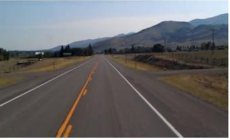

input image


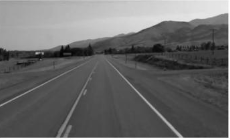

grayscale image


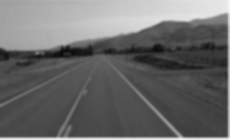

guassian blur


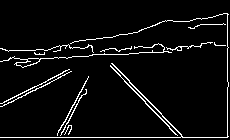

canny edge detection image


In [12]:
image_path = 'image.jpg'
image = cv2.imread(image_path)

# Convert the image to grayscale
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
kernel_size = 5
blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)

# Apply Canny edge detection
low_t = 50
high_t = 150
edges = cv2.Canny(blur, low_t, high_t)

# Display the original, grayscale, blurred, and edge images
cv2_imshow(image)
print("input image")
cv2_imshow(grayscale)
print("grayscale image")
cv2_imshow(blur)
print("guassian blur")
cv2_imshow(edges)
print("canny edge detection image")

**Region Selection**

Till now we have converted frames from RGB to Grayscale, applied Gaussian Blur to reduce noise and used canny edge detection. Next we will select the region where we want to detect road lanes.

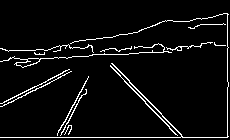

canny edge detection image


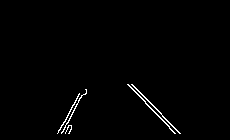

region selection


In [13]:
# Define the region_selection function
def region_selection(image):
    mask = np.zeros_like(image)
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    rows, cols = image.shape[:2]
    bottom_left = [cols * 0.1, rows * 0.95]
    top_left = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# Load an example image (you can replace this with your image)
image_path = 'image.jpg'
image = cv2.imread(image_path)

# Convert the image to grayscale
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
kernel_size = 5
blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)

# Apply Canny edge detection
low_t = 50
high_t = 150
edges = cv2.Canny(blur, low_t, high_t)

# Apply region selection
region = region_selection(edges)

# Display the original, grayscale, blurred, edge, and region-selected images

cv2_imshow(edges)
print("canny edge detection image")
cv2_imshow(region)
print("region selection")



**Now we will be identifying straight lines in the output image from the above function using Probabilistic Hough Transform**

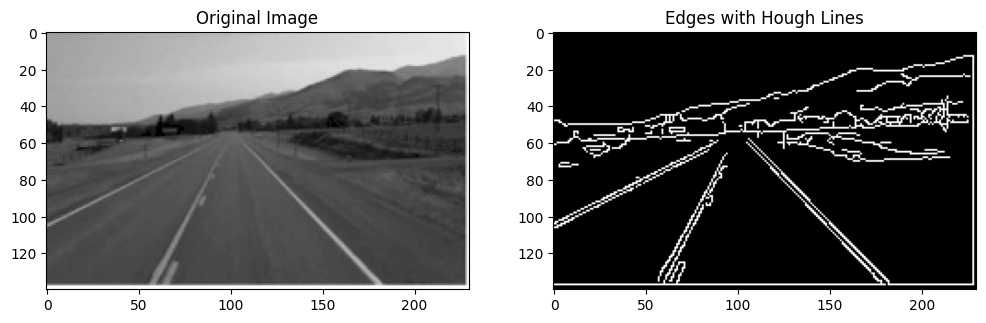

In [15]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hough_transform(image):
    rho = 1
    theta = np.pi/180
    threshold = 20
    minLineLength = 20
    maxLineGap = 500

    lines = cv2.HoughLinesP(image, rho=rho, theta=theta, threshold=threshold,
                            minLineLength=minLineLength, maxLineGap=maxLineGap)
    return lines

# Assuming the input image is named "image.jpg"
image_name = "image.jpg"

# Read the image
image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

# Apply some preprocessing to the image (e.g., edge detection)
edges = cv2.Canny(image, 50, 150)

# Apply Hough Transform
lines = hough_transform(edges)

# Display the original image and the lines
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edges with Hough Lines')
plt.show()


**Plotting Lines on video frames**

Now that we have received the coordinates using Hough Transform, we will plot them on our original image(frame) but as we can see that we are getting coordinates of more than 2 lines so we will first find slope of left and right lane and then overlay them over the original image.

We have define 4 functions here to help draw left and right lane on our input frame:

**1.Average_Slope_Intercept:** This function takes in the hough transform lines and calculate their slope and intercept. If the slope of a line is negative then it belongs to left lane else the line belongs to the right lane. Then we calculate the weighted average slope and intercept of left lane and right lanes.

**2.Pixel_Points:** By using slope, intercept and y-values of the line we find the x values for the line and returns the x and y coordinates of lanes as integers.

**3.Lane_Lines:** The function where Average_Slope_Intercept and Pixel Points are called and coordinates of right lane and left lane are calculated.

**4.Draw_Lane_Lines:** This function draws the left lane and right lane of the road on the input frame. Returns the output frame which is then stored in the variable “processed” in our driver function “process_video”.

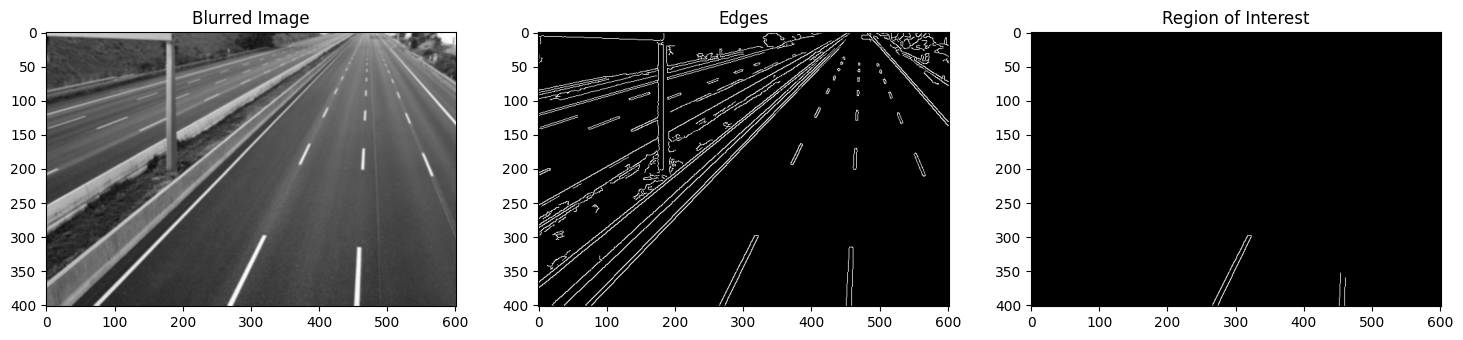

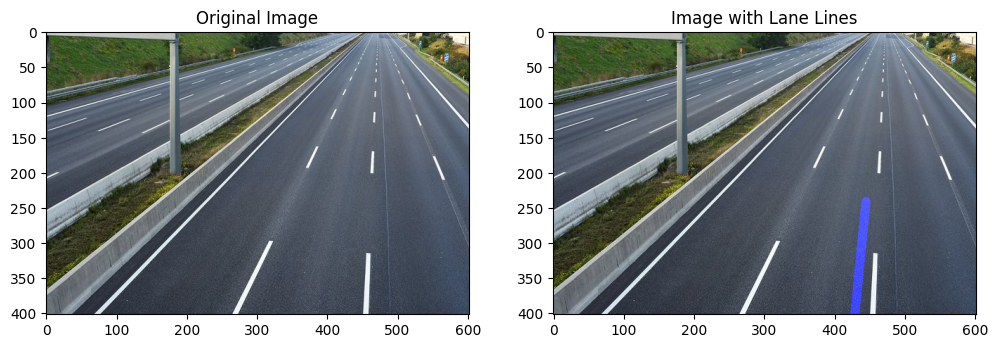

In [20]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

def filter_lines(lines, slope_threshold=0.5):
    filtered_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            if abs(slope) > slope_threshold:
                filtered_lines.append(line)
    return filtered_lines

def weighted_average(lines):
    weights = [length(line) for line in lines]
    avg_slope = np.dot(weights, [slope(line) for line in lines]) / np.sum(weights)
    avg_intercept = np.dot(weights, [intercept(line) for line in lines]) / np.sum(weights)
    return avg_slope, avg_intercept

def length(line):
    x1, y1, x2, y2 = line[0]
    return np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

def slope(line):
    x1, y1, x2, y2 = line[0]
    return (y2 - y1) / (x2 - x1)

def intercept(line):
    x1, y1, x2, y2 = line[0]
    return y1 - slope(line) * x1

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def average_slope_intercept(lines):
    left_lines = []
    left_weights = []
    right_lines = []
    right_weights = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))

    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None

    return left_lane, right_lane

def pixel_points(y1, y2, line):
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line

def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

# Load the image from Google Colab environment
image_path = '/content/img.jpg'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Add Gaussian Blur
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Apply edge detection (Canny)
edges = cv2.Canny(blurred_image, 50, 150)

# Define region of interest
height, width = image.shape[:2]
roi_vertices = np.array([[(100, height), (width/2-50, height/2+50), (width/2+50, height/2+50), (width-100, height)]], dtype=np.int32)
roi_image = region_of_interest(edges, roi_vertices)

# Apply Hough Transform
lines = cv2.HoughLinesP(roi_image, rho=1, theta=np.pi/180, threshold=30, minLineLength=20, maxLineGap=100)

# Filter lines based on slope
filtered_lines = filter_lines(lines)

# Get the lane lines
left_line, right_line = lane_lines(image, filtered_lines)

# Draw the lane lines on the original image
result_image = draw_lane_lines(image, [left_line, right_line])

# Visualize the intermediate steps
plt.figure(figsize=(18, 6))
plt.subplot(131), plt.imshow(blurred_image, cmap='gray'), plt.title('Blurred Image')
plt.subplot(132), plt.imshow(edges, cmap='gray'), plt.title('Edges')
plt.subplot(133), plt.imshow(roi_image, cmap='gray'), plt.title('Region of Interest')
plt.show()

# Display the original image and the result
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(122), plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)), plt.title('Image with Lane Lines')
plt.show()
